In [4]:
import pandas as pd

In [5]:
# 读取设备上报数据
df = pd.read_csv('./device-2.csv')

df.head()

,ts,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,0.002938,76.000000,False,0.005241,False,0.013628,19.700001
1,1.594512e+09,0.002905,75.800003,False,0.005199,False,0.013509,19.700001
2,1.594512e+09,0.002938,75.800003,False,0.005241,False,0.013628,19.700001
3,1.594512e+09,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
4,1.594512e+09,0.002840,76.000000,False,0.005114,False,0.013275,19.799999


数据预处理

In [6]:
# ts 转为 13 位 Unix Timestamp
df['ts'] = df.apply(lambda x: x*1000, axis=0)
# 以 ts 作为索引
df = df.set_index('ts')

df.head(1)

,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,
1.594512e+12,0.002938,76.0,False,0.005241,False,0.013628,19.700001


In [49]:
# 以 temp 为例进行后续处理
temp_ts = df['temp']
temp_ts.head()

ts
1.594512e+12    19.700001
1.594512e+12    19.700001
1.594512e+12    19.700001
1.594512e+12    19.700001
1.594512e+12    19.799999
Name: temp, dtype: float64

构建时间序列模型

In [41]:
from statsmodels.tsa import stattools

# ar 与 ma 的参数取值一般为 0~4
# 遍历所有组合, 选择指标最好的参数组合
select_res = stattools.arma_order_select_ic(temp_ts, max_ar=4, max_ma=4)
select_res

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated i

{'bic':                0              1              2              3              4
 0  218854.214828  211214.323219  206979.674866  204023.364395  201866.626595
 1  207751.090416            NaN            NaN            NaN            NaN
 2  201683.952345            NaN            NaN            NaN            NaN
 3  197674.878170            NaN            NaN            NaN            NaN
 4  194905.532284            NaN            NaN            NaN            NaN,
 'bic_min_order': (4, 0)}

In [42]:
# 选取评价结果最好的参数
params = select_res.bic_min_order
params

(4, 0)

In [43]:
from statsmodels.tsa import arima_model

# 根据评价结果, (4, 0) 表现最好
ts_model = arima_model.ARMA(temp_ts, order=params).fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn

In [44]:
# 查看模型描述
ts_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   temp   No. Observations:               111814
Model:                     ARMA(4, 0)   Log Likelihood              -97417.892
Method:                       css-mle   S.D. of innovations              0.578
Date:                Wed, 30 Mar 2022   AIC                         194847.785
Time:                        15:45:06   BIC                         194905.532
Sample:                             0   HQIC                        194865.222
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.3626      0.005   4087.669      0.000      19.353      19.372
ar.L1.temp     0.1642      0.003     55.581      0.000       0.158       0.170
ar.L2.temp     0.1564      0.003     52.909      0.000       0.151       0.162
ar.L3.temp     0.1576      0.003     53.298      0.000       0.152       0.163
ar.L4.temp     0.1567      0.003     53.065      0.000       0.151       0.163
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1914           -0.0000j            1.1914           -0.0000
AR.2           -0.1864           -1.7032j            1.7134           -0.2673
AR.3           -0.1864           +1.7032j            1.7134            0.2673
AR.4           -1.8242           -0.0000j            1.8242           -0.5000
-----------------------------------------------------------------------------
"""

In [79]:
# 使用模型进行预测
temp_ts_predict = ts_model.predict()
temp_ts_predict

ts
1.594512e+12    19.362556
1.594512e+12    19.466355
1.594512e+12    19.520100
1.594512e+12    19.553909
1.594512e+12    19.576806
                  ...    
1.595203e+12    19.259347
1.595203e+12    19.259347
1.595203e+12    19.259347
1.595203e+12    19.259347
1.595203e+12    19.259347
Length: 111814, dtype: float64

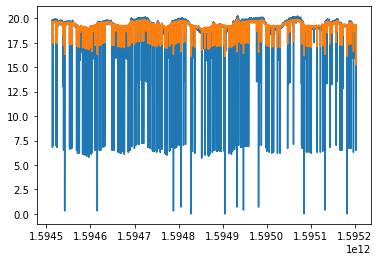

In [46]:
# 对比实际数据和预测结果
import matplotlib.pyplot as plt

plt.plot(temp_ts)
plt.plot(temp_ts_predict)

构建聚类模型

In [50]:
# 以实际值与预测值的偏差作为聚类值
temp_ts_bias = temp_ts - temp_ts_predict
temp_ts_bias

ts
1.594512e+12    0.337445
1.594512e+12    0.233646
1.594512e+12    0.179901
1.594512e+12    0.146091
1.594512e+12    0.223193
                  ...   
1.595203e+12   -0.059346
1.595203e+12   -0.059346
1.595203e+12   -0.059346
1.595203e+12   -0.059346
1.595203e+12   -0.059346
Length: 111814, dtype: float64

In [51]:
import numpy as np
from sklearn.cluster import KMeans

# 使用 KMeans 将数据分为三类
cluster_model = KMeans(n_clusters=3)
cluster_model.fit(np.array(temp_ts_bias).reshape(-1, 1))
labels = cluster_model.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
# 将实际值、预测值、分类集成到一起
temp_ts_df = pd.DataFrame(columns=['temp'], data=temp_ts.values, index=temp_ts.index)
temp_ts_df['predict'] = temp_ts_predict.values
temp_ts_df['label'] = labels
temp_ts_df.describe()

,temp,predict,label
count,111814.000000,111814.000000,111814.000000
mean,19.362549,19.362555,0.016358
std,0.643789,0.282924,0.175887
min,0.000000,15.219139,0.000000
25%,19.100000,19.195854,0.000000
50%,19.400000,19.370571,0.000000
75%,19.700001,19.576806,0.000000
max,20.200001,19.894266,2.000000


In [76]:
# label=0 均值偏差最小, 认为“可信”
print(abs(temp_ts_df[temp_ts_df['label'] == 0]['temp'].mean() - temp_ts_df[temp_ts_df['label'] == 0]['predict'].mean()))
temp_ts_df[temp_ts_df['label'] == 0].head()

0.005802239286083477


,temp,predict,label
ts,,,
1.594512e+12,19.700001,19.362556,0
1.594512e+12,19.700001,19.466355,0
1.594512e+12,19.700001,19.520100,0
1.594512e+12,19.700001,19.553909,0
1.594512e+12,19.799999,19.576806,0


In [77]:
# label=1 均值偏差最大, 认为“不可信”
print(abs(temp_ts_df[temp_ts_df['label'] == 1]['temp'].mean() - temp_ts_df[temp_ts_df['label'] == 1]['predict'].mean()))
temp_ts_df[temp_ts_df['label'] == 1].head()

13.243485373113279


,temp,predict,label
ts,,,
1.594514e+12,6.8,19.528958,1
1.594514e+12,7.0,19.624653,1
1.594521e+12,7.0,19.640297,1
1.594524e+12,6.8,19.513314,1
1.594539e+12,6.5,19.339254,1


In [78]:
# label=2 均值偏差中等, 认为“不确定”
print(abs(temp_ts_df[temp_ts_df['label'] == 2]['temp'].mean() - temp_ts_df[temp_ts_df['label'] == 2]['predict'].mean()))
temp_ts_df[temp_ts_df['label'] == 2].head()

1.921104698580276


,temp,predict,label
ts,,,
1.594514e+12,19.600000,17.427805,2
1.594514e+12,19.600000,17.526556,2
1.594514e+12,19.600000,17.496176,2
1.594514e+12,19.600000,17.507185,2
1.594514e+12,19.799999,17.523271,2


In [82]:
# 按类别分离
K = 3
df_label = []
for i in range(K):
    df_label.append(temp_ts_df[temp_ts_df['label'] == i])

# 计算每种类别的均值偏差
for i in range(K):
    df = df_label[i]
    avg = abs(df_label[i]['temp'].mean() - df_label[i]['predict'].mean())
    df_label[i] = [df, avg]

In [110]:
# 按照均值偏差升序排列
# 认为偏差最小为"可信", 其次为"不确定", 最大为"不可信"
df_label.sort(key=lambda x: x[1])
reliable_df = pd.DataFrame(columns=['label'])
neural_df = pd.DataFrame(columns=['label'])
unreliable_df = pd.DataFrame(columns=['label'])

print(df_label[0][1], df_label[1][1], df_label[2][1])

0.005802239286083477 1.921104698580276 13.243485373113279


In [104]:
# 但也需要阈值进行控制, 否则全部可信的数据也会被强行分为三类
NEURAL_THREHOLD = 0.01 * temp_ts_df['temp'].mean()
UNRELIABLE_THRESHOLD = 0.15 * temp_ts_df['temp'].mean()
print(NEURAL_THREHOLD, UNRELIABLE_THRESHOLD)

0.19362549451175157 2.904382417676273


In [111]:
# 可信
reliable_df = df_label[0][0]
reliable_df.count()

temp       110815
predict    110815
label      110815
dtype: int64

In [112]:
# 不确定
neural_bias = df_label[1][1] - df_label[0][1]
print(neural_bias)

if neural_bias < NEURAL_THREHOLD:
    reliable_df = pd.concat([reliable_df, df_label[1][0]])
elif neural_bias >= NEURAL_THREHOLD and neural_bias < UNRELIABLE_THRESHOLD:
    neural_df = df_label[1][0]
else:
    unreliable_df = df_label[1][0]

print(reliable_df['label'].count(), neural_df['label'].count(), unreliable_df['label'].count())

1.9153024592941925
110815 830 0


In [114]:
# 不可信
unreliable_bias = df_label[2][1] - df_label[0][1]
print(unreliable_bias)

if unreliable_bias < NEURAL_THREHOLD:
    reliable_df = pd.concat([reliable_df, df_label[1][0]])
elif unreliable_bias >= NEURAL_THREHOLD and unreliable_bias < UNRELIABLE_THRESHOLD:
    if neural_df.empty:
        neural_df = df_label[2][0]
    else:
        neural_df = pd.concat([neural_bias, df_label[2][0]])
else:
    if unreliable_df.empty:
        unreliable_df = df_label[2][0]
    else:
        unreliable_df = pd.concat([unreliable_df, df_label[2][0]])

print(reliable_df['label'].count(), neural_df['label'].count(), unreliable_df['label'].count())

13.237683133827195
110815 830 169


In [127]:
print(temp_ts.describe())

count    111814.000000
mean         19.362549
std           0.643789
min           0.000000
25%          19.100000
50%          19.400000
75%          19.700001
max          20.200001
Name: temp, dtype: float64
